# Импорт библиотек

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from pathlib import Path
from sklearn.metrics import mean_squared_error
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
import pymorphy2

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Основные методы и их описание

Получим список стоп-слов русского языка

In [ ]:
def get_list_stop():
  stop_words = list(get_stop_words('russian'))
  print(f'Из библиотеки stop_words - {len(stop_words)} слов')
  stop_words_nltk = list(stopwords.words('russian'))
  print(f'Из nltk - {len(stop_words_nltk)} слов')
  stop_words.extend(stop_words_nltk)
  print(f'Всего - {len(stop_words)} слов')
  return stop_words

In [ ]:
stop_words = get_list_stop()

Из библиотеки stop_words - 421 слов
Из nltk - 151 слов
Всего - 572 слов


In [ ]:
print(f'Примеры стоп слов {stop_words[50:70]} ...')

Примеры стоп слов ['ваш', 'вон', 'вот', 'все', 'всю', 'вся', 'всё', 'где', 'год', 'два', 'две', 'дел', 'для', 'его', 'ему', 'еще', 'ещё', 'или', 'ими', 'имя'] ...


Тексты

In [ ]:
path_text1 = 'text_1.txt'
path_text2 = 'text_2.txt'
path_text3 = 'text_3.txt'

Лемматизатор с русского языка

In [ ]:
morph = pymorphy2.MorphAnalyzer()

Этапы обработки текста: декодирование, токенизация, удаление стоп-слов, нормализация, лемматизация.

In [ ]:
def text_processing(fname, stop_words, morph):
  tokens = []
  with open(fname, 'r', encoding = "utf_8", errors="ignore") as read_txt:
    print(Path(fname).name.replace('.txt', ''))
    text = read_txt.read()
    tokens_list = nltk.word_tokenize(text)
    print(f'Всего в изначальном тексте {len(tokens_list)} токенов')
    tokens.append(len(set(tokens_list)))
    print(f'Из них уникальных токенов - {tokens[-1]}')
    print('---')
    re_str = r'\b[а-яА-Я]+\b'
    tokens_list = [token.lower() for token in tokens_list if re.search(re_str, token)]
    print(f'После нормализации остается {len(tokens_list)}')
    tokens.append(len(set(tokens_list)))
    print(f'Из них уникальных - {tokens[-1]}')
    print('---')
    tokens_list = [token for token in tokens_list if not token in stop_words]
    print(f'После удаления стоп-слов осталось {len(tokens_list)}')
    tokens.append(len(set(tokens_list)))
    print(f'Из них уникальных - {tokens[-1]}')
    print('---')
    tokens_list = [morph.parse(token)[0].normal_form for token in tokens_list]
    tokens.append(len(set(tokens_list)))
    print(f'После лемматизации - {tokens[-1]} уникальных')
    print('---')

  plt.bar(['изначально', 'нормализация', 'удалены \n стоп-слова', 'лемматизация'], tokens)

  for i, value in enumerate(tokens):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom')

  plt.title('Изменение числа токенов')
  plt.xlabel('Этап')
  plt.ylabel('Количество токенов')

  plt.show()
  return tokens_list

__Закон ципфа__

$t_1, \dots, t_N -$ токены, отранжированные по убыванию частоты

$f_1, \dots, f_N -$ соответствующие частоты

$$
  f_i=\frac{c}{i^k}
$$

Закон Ципфа утверждает, что частота слов обратно пропорциональна их рангу.

Вероятности вхождения каждого токена. График вероятностей токенов, упорядоченных по убыванию. Распределение частот по закону Ципфа. Оценка сходства между истинными частотами и теоретическими по MSE.

In [ ]:
def plot_zipf_actual_freq(tokens_list):
  len_tokens = len(tokens_list)
  token_counts = Counter(tokens_list)
  sorted_tokens = token_counts.most_common()
  frequencies = [count / len_tokens  for token, count in sorted_tokens]
  ranks = np.array(range(len(token_counts))) + 1
  c = frequencies[0] * ranks[0] # constant
  zipf_law = c / ranks
  mse = mean_squared_error(frequencies, zipf_law)


  plt.figure(figsize=(10, 5))
  plt.plot(ranks, frequencies, label='Actual')
  plt.plot(ranks, zipf_law, color='red', label='Zipf')
  plt.xlabel('Ранк слова')
  #plt.yscale('log')
  plt.ylabel('Частота')
  plt.title(f'Сходство по MSE - {mse}')
  plt.legend()
  plt.show()

  return sorted_tokens, frequencies

Уровни отсечки от начала и от конца массива токенов из множества упорядоченных по частоте встречаемости. Средние значения данных уровней. Значения на отсечках входят в список ''значимых токенов''

In [ ]:
def make_cutoff(token_counts, frequencies):
  # слова, имеющие высокую частоту встречаемости (малая информативность)
  most_popular = 0
  for upper, (token, count) in enumerate(token_counts):
    if count != 1:
      most_popular += frequencies[upper]
    if most_popular >= 0.05:
      upper += 1
      break
  print(f'Наиболее частые первые {upper} слов, их общая частота - {most_popular}')

  # слова, имеющие частоту встречаемости - 1 (никакой информативности)
  most_rare = 0
  for lower in reversed(range(len(token_counts))):
    if token_counts[lower][1] == 1:
      most_rare += frequencies[lower]
    else:
      lower += 1
      break
  print(f'Редкие слова с {lower + 1} позиции, их общая частота - {most_rare}')

  ranks = np.array(range(len(token_counts))) + 1

  plt.figure(figsize=(10, 5))
  plt.plot(ranks, frequencies, label='Распределение слов')
  for x, label, c in zip([upper + 1, lower], [token_counts[upper][0], token_counts[lower - 1][0]], ['g', 'r']):
    plt.axvline(x=x, color=c)
    plt.text(x, 0, f'{x}-{label}', verticalalignment='bottom', horizontalalignment='center')
  plt.xlabel('Ранк слова')
  plt.xscale('log')
  plt.ylabel('Частота')
  #plt.yscale('log')
  plt.title(f'Значимые слова - {1 - most_popular - most_rare}\nСреднее значение уровней {(upper + 1 + lower)//2}')
  plt.legend()
  plt.show()

# Текст №1

text_1
Всего в изначальном тексте 8002 токенов
Из них уникальных токенов - 3177
---
После нормализации остается 6525
Из них уникальных - 2966
---
После удаления стоп-слов осталось 4146
Из них уникальных - 2726
---
После лемматизации - 1904 уникальных
---


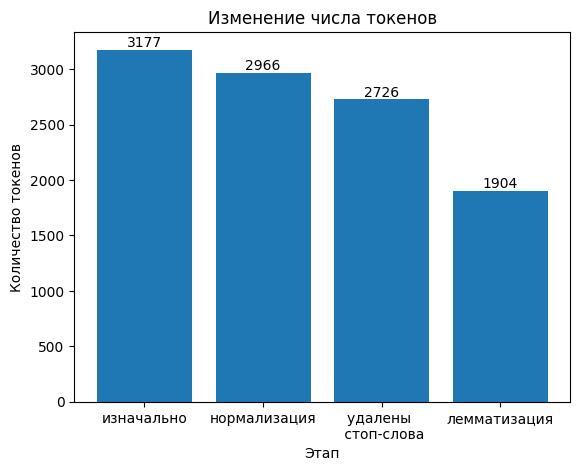

In [ ]:
tokens_list = text_processing(path_text1, stop_words, morph)

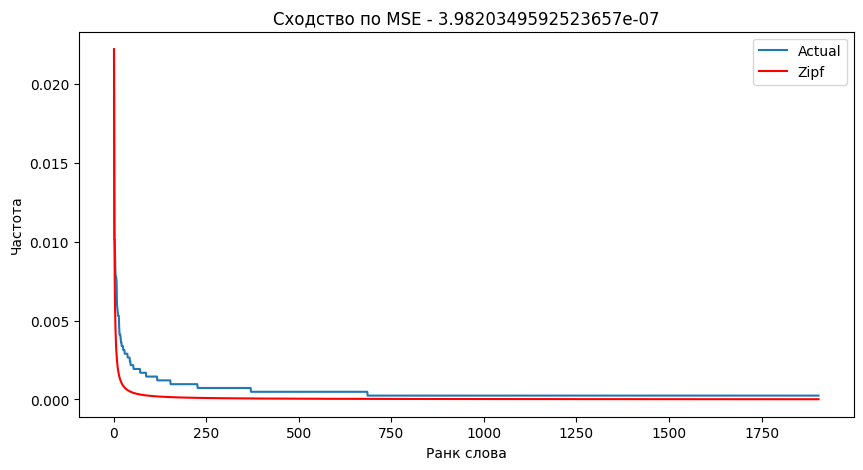

In [ ]:
token_counts, frequencies = plot_zipf_actual_freq(tokens_list)

Близкое к нулю значение MSE указывает на то, что закон Ципфа довольно хорошо описывает распределение частот слов в тексте №1.

Наиболее частые первые 4 слов, их общая частота - 0.05137481910274964
Редкие слова с 686 позиции, их общая частота - 0.29401833092137314


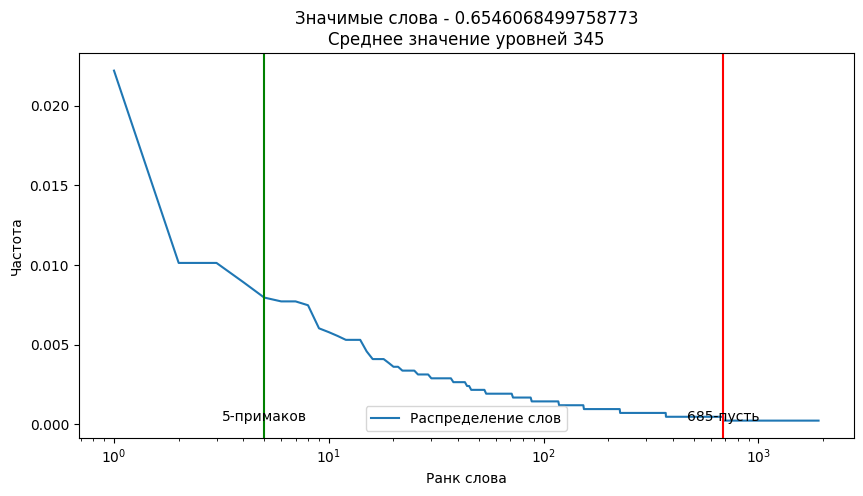

In [ ]:
make_cutoff(token_counts, frequencies)

Слова, имеющие значительное влияние в тексте и несущие основную информацию о нем, занимают по нашим оценкам 65%

# Текст №2

text_2
Всего в изначальном тексте 3198 токенов
Из них уникальных токенов - 1364
---
После нормализации остается 2562
Из них уникальных - 1285
---
После удаления стоп-слов осталось 1492
Из них уникальных - 1098
---
После лемматизации - 820 уникальных
---


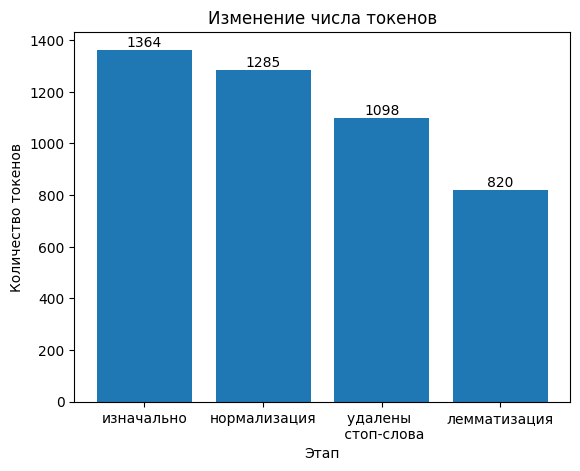

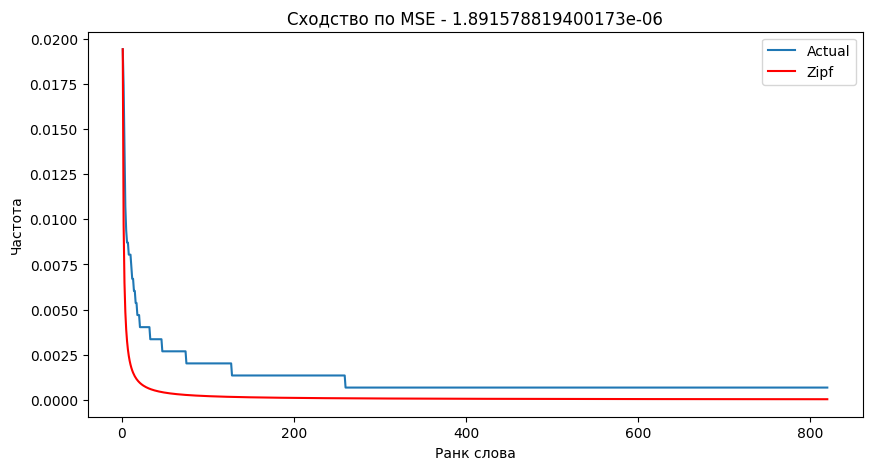

Наиболее частые первые 3 слов, их общая частота - 0.05093833780160858
Редкие слова с 260 позиции, их общая частота - 0.3760053619302951


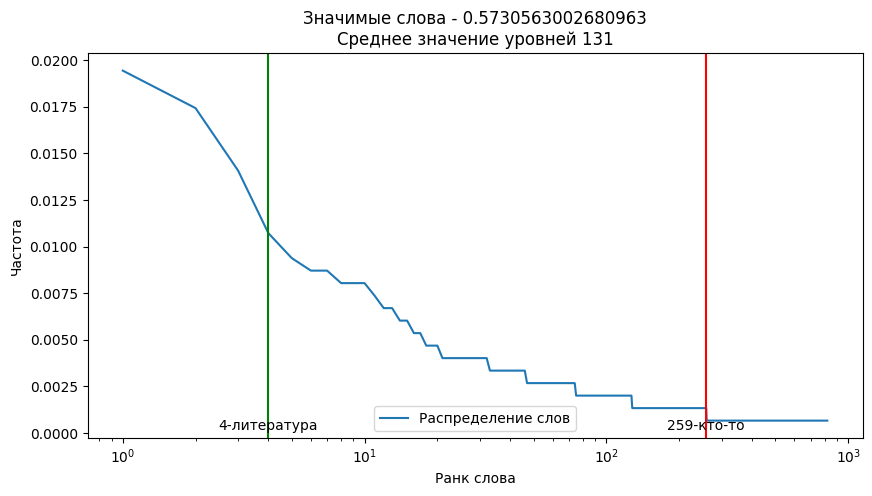

In [ ]:
tokens_list = text_processing(path_text2, stop_words, morph)
token_counts, frequencies = plot_zipf_actual_freq(tokens_list)
make_cutoff(token_counts, frequencies)

#Текст №3

text_3
Всего в изначальном тексте 1594 токенов
Из них уникальных токенов - 793
---
После нормализации остается 1358
Из них уникальных - 743
---
После удаления стоп-слов осталось 818
Из них уникальных - 609
---
После лемматизации - 482 уникальных
---


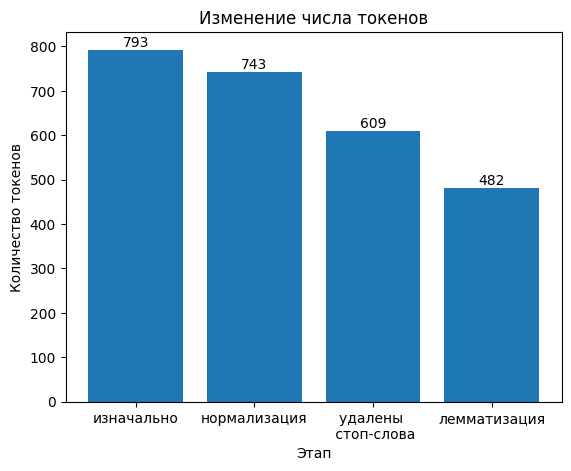

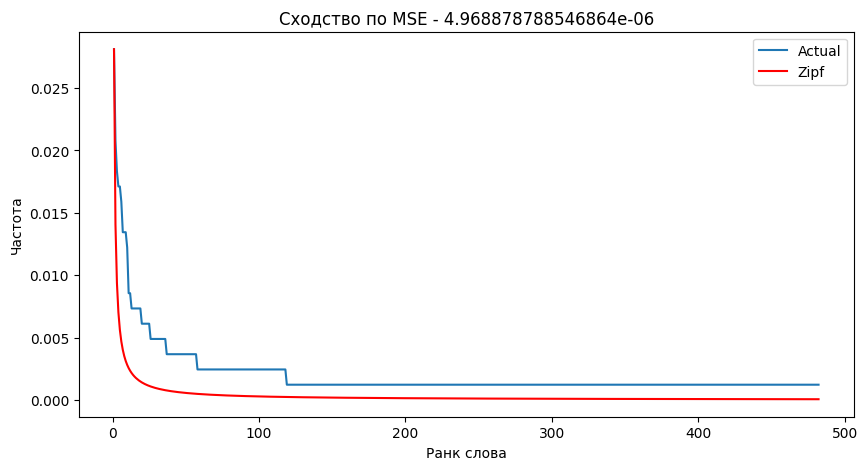

Наиболее частые первые 3 слов, их общая частота - 0.06723716381418093
Редкие слова с 119 позиции, их общая частота - 0.44498777506112197


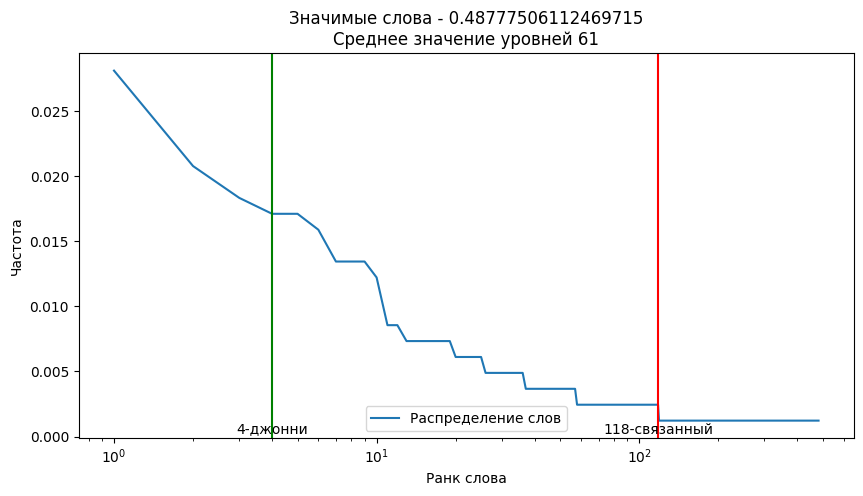

In [ ]:
tokens_list = text_processing(path_text3, stop_words, morph)
token_counts, frequencies = plot_zipf_actual_freq(tokens_list)
make_cutoff(token_counts, frequencies)

Аналогичные первому тексту выводы для второго и третьего текстов